## SIM Training by Stein's Method

In [1]:
import numpy as np
from matplotlib import pylab as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, roc_auc_score

from pysim import SimClassifier

## pySIM - A python package for Sparse SIM 

**To install**:
    
```sheel
    pip install git+https://github.com/Zebinyang/pysim.git
```

Note pysim will call the R package fps (https://github.com/vqv/fps) using rpy2 interface. 

```python
from pysim import SimClassifier
clf = SimClassifier(method="first_order", spline="a_spline", reg_lambda=0.1, reg_gamma=10, knot_num=20, degree=2, random_state=0)
## clf.fit(x, y)
```

**Usage**

**Hyperparameters**

- method: the base method for estimating the projection coefficients in sparse SIM. default="first_order"

        "first_order": First-order Stein's Identity via sparse PCA solver

        "second_order": Second-order Stein's Identity via sparse PCA solver

        "first_order_thres": First-order Stein's Identity via hard thresholding (A simplified verison)        
    
- spline: The type of spline method. default="a_spline"

        "p_spline": p-spline (from pygam package)
    
        "p_spline_mono": p-spline with monotonic constraint (from pygam package)
    
        "a_spline": adaptive spline where knots are automatically selected (see Goepp, V., Bouaziz, O. and Nuel, G., 2018. Spline regression with automatic knot selection. arXiv preprint arXiv:1808.01770.)

- reg_lambda: The regularization strength of sparsity of beta. default=0.1, from 0 to 1 

- reg_gamma: The regularization strength of the spline algorithm. default=10, from 0 to $+\infty$

- degree: The order of the spline basis. default=2

- knot_num: The number of knots spanned uniformly over the domain. default=20

- random_state: the random seed. default=0

# Case 1: Sine Ridge Function

- covariates: $x\sim N(0, 0.3^2)$
- ridge function: $ f(u) = \sin{(u\pi)} $
- projection: $ u = \beta^{T} x $, where $\beta$ has 5 non-zero entries
- noise: $N(0, 1)$
- sample size: 10000
- feature size: 100

In [2]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.sin(np.pi*(np.dot(x, beta))) + 0.1 * np.random.randn(n_samples)
ymu = np.mean(y)
y[y > ymu] = 1
y[y <= ymu] = 0

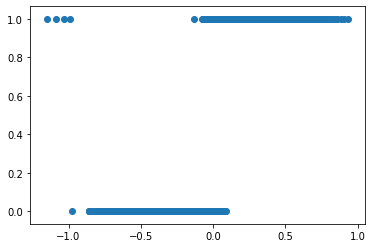

In [3]:
plt.scatter(np.dot(x, beta), y)

The best hyperparameter combination can be selected via cross-validation

In [4]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "reg_lambda": [0.01, 0.05, 0.1],
              "reg_gamma": np.logspace(-1, 1, 3)}
grid = GridSearchCV(SimClassifier(degree=2, knot_num=20, spline="a_spline", random_state=0), 
                    cv=KFold(3, shuffle=True, random_state=0), 
                    scoring={"auc": make_scorer(roc_auc_score)},
                    param_grid=param_grid, n_jobs=-1, verbose=2, refit="auc", error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  54 | elapsed:   34.1s remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  39 out of  54 | elapsed:   46.1s remaining:   17.7s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   49.8s finished


CPU times: user 5.55 s, sys: 20.9 s, total: 26.5 s
Wall time: 51.3 s


In [5]:
grid.best_params_

{'method': 'first_order', 'reg_gamma': 0.1, 'reg_lambda': 0.05}

**NB**: The first-order Setin's method is selected, as $\mathbb{E}[f^{\prime\prime}(u)]=0$. Therefore, the second order method cannot provide any information about the projection coefficients. 

In this case, the first-order Setin's method is selected. 

In [6]:
clf = grid.best_estimator_
clf

SimClassifier(degree=2, knot_num=20, method='first_order', random_state=0,
              reg_gamma=0.1, reg_lambda=0.05, spline='a_spline')

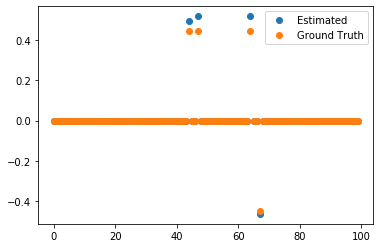

In [7]:
plt.plot(clf.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

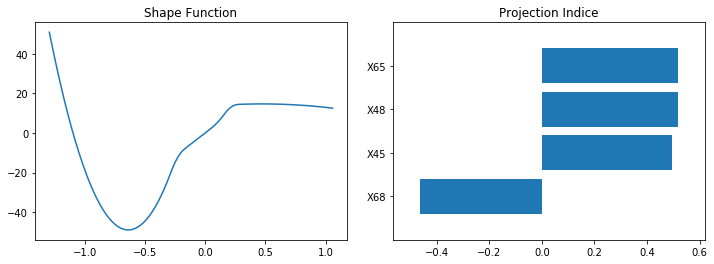

In [8]:
grid.best_estimator_.visualize()

In [9]:
roc_auc_score(y, grid.predict_proba(x))

0.995407851905614

## Case 2: Quadratic Ridge Function

- covariates: $x\sim N(0, 0.3^2)$
- ridge function: $ f(u) = u^{2} $
- projection: $ u = \beta^{T} x $, where $\beta$ has 5 non-zero entries
- noise: $N(0, 1)$
- sample size: 10000
- feature size: 100

In [10]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = 5 * np.dot(x, beta) ** 2 + 0.1 * np.random.randn(n_samples)
ymu = np.mean(y)
y[y > ymu] = 1
y[y <= ymu] = 0

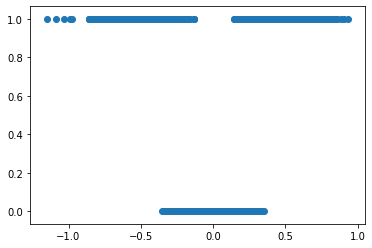

In [11]:
plt.scatter(np.dot(x, beta), y)

In [12]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "reg_lambda": [0.01, 0.05, 0.1],
              "reg_gamma": np.logspace(-1, 1, 3)}
grid = GridSearchCV(SimClassifier(degree=2, knot_num=20, spline="a_spline", random_state=0), 
                    cv=KFold(3, shuffle=True, random_state=0), 
                    scoring={"auc": make_scorer(roc_auc_score)},
                    param_grid=param_grid, n_jobs=-1, verbose=2, refit="auc", error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  54 | elapsed:   12.3s remaining:   48.3s
[Parallel(n_jobs=-1)]: Done  39 out of  54 | elapsed:   17.4s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   40.9s finished


CPU times: user 5.52 s, sys: 20.8 s, total: 26.3 s
Wall time: 43.8 s


In [13]:
grid.best_params_

{'method': 'second_order', 'reg_gamma': 10.0, 'reg_lambda': 0.05}

**NB**: The second-order Setin's method is selected, as $\mathbb{E}[f^{\prime}(u)]=0$. Therefore, the first order method cannot provide any information about the projection coefficients. 

In [14]:
clf = grid.best_estimator_
clf

SimClassifier(degree=2, knot_num=20, method='second_order', random_state=0,
              reg_gamma=10.0, reg_lambda=0.05, spline='a_spline')

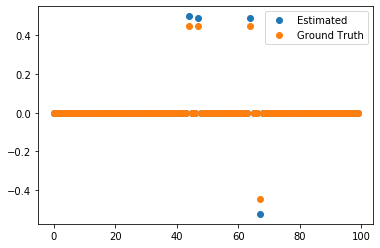

In [15]:
plt.plot(clf.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

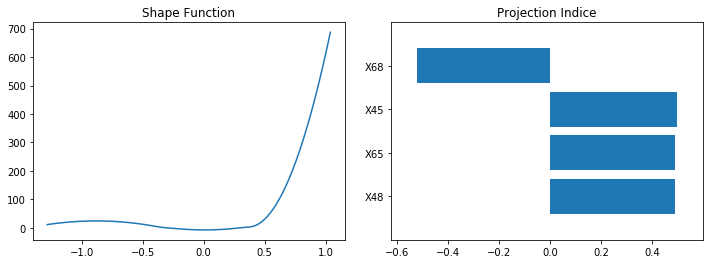

In [16]:
grid.best_estimator_.visualize()

In [17]:
roc_auc_score(y, grid.predict_proba(x))

0.986785480555321

In [20]:
import scipy
import numpy as np
import pandas as pd 
from scipy.linalg import cholesky
from matplotlib import pyplot as plt
from abc import ABCMeta, abstractmethod

from sklearn.utils.extmath import softmax
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, check_X_y, column_or_1d
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from patsy import dmatrix, build_design_matrices


class BaseASpline(BaseEstimator, metaclass=ABCMeta):
    """
        Base class for ASpline classification and regression.
     """

    @abstractmethod
    def __init__(self, knot_num=20, reg_gamma=0.1, xmin=-1, xmax=1, degree=2, epsilon=0.00001, threshold=0.99, maxiter=10):

        self.knot_num = knot_num
        self.reg_gamma = reg_gamma
        self.xmin = xmin
        self.xmax = xmax
        self.degree = degree
        self.epsilon = epsilon
        self.threshold = threshold
        self.maxiter = maxiter

    @staticmethod
    def diff_matrix(order, knot_num):
        results = [] # a container to collect the rows
        n_rows = order + 2
        for _ in range(n_rows): 
            row = [1] # a starter 1 in the row
            if results: # then we are in the second row or beyond
                last_row = results[-1] # reference the previous row
                row.extend([sum(pair) for pair in zip(last_row, last_row[1:])])
                row.append(1)
            results.append(row) # add the row to the results.

        diss_operator = [] # a container to collect the rows
        for i, item in enumerate(np.array(row)):
            diss_operator.append(item * (-1) ** i)
        diss_operator.reverse()
        D = np.zeros((knot_num, knot_num + order + 1), dtype=np.float32)
        for i in range(knot_num):
            D[i,i:(i+order+2)] = diss_operator
        return D

    def _validate_hyperparameters(self):
        
        if not isinstance(self.degree, int):
            raise ValueError("degree must be an integer, got %s." % self.degree)

        if self.degree < 0:
            raise ValueError("degree must be >= 0, got" % self.degree)
        
        if not isinstance(self.knot_num, int):
            raise ValueError("knot_num must be an integer, got %s." % self.knot_num)

        if self.knot_num <= 0:
            raise ValueError("knot_num must be > 0, got" % self.knot_num)

        if self.reg_gamma <= 0:
            raise ValueError("reg_gamma must be > 0, got %s." % self.reg_gamma)

        if self.xmin >= self.xmax:
            raise ValueError("xmin must be < xmax, got %s and %s." % (self.xmin, self.xmax))

        if self.epsilon <= 0:
            raise ValueError("epsilon must be > 0, got %s." % self.epsilon)

        if self.threshold <= 0:
            raise ValueError("threshold must be > 0, got %s." % self.threshold)

        if not isinstance(self.maxiter, int):
            raise ValueError("maxiter must be an integer, got %s." % self.maxiter)

        if self.maxiter <= 0:
            raise ValueError("maxiter must be > 0, got" % self.maxiter)

            
    def visualize(self):

        check_is_fitted(self, "coef_")

        fig = plt.figure(figsize=(6, 4))
        xgrid = np.linspace(self.xmin, self.xmax, 100).reshape([-1, 1])
        ygrid = self.decision_function(xgrid)
        plt.plot(xgrid, ygrid)
        plt.title("Shape Function", fontsize=12)
        plt.show()

    def decision_function(self, x):

        check_is_fitted(self, "coef_")
        x = x.copy()
        x[x < self.xmin] = self.xmin
        x[x > self.xmax] = self.xmax
        design_matrix = np.asarray(build_design_matrices([self.selected_xphi_.design_info],
                                         {"x": x, "knots": self.selected_knots_, "degree": self.degree})[0])
        pred = np.dot(design_matrix, self.coef_)
        return pred


class ASplineRegressor(BaseASpline, RegressorMixin):

    def __init__(self, knot_num=20, reg_gamma=0.1, xmin=-1, xmax=1, degree=2, epsilon=0.00001, threshold=0.99, maxiter=10):

        super(ASplineRegressor, self).__init__(knot_num=knot_num,
                                  reg_gamma=reg_gamma,
                                  xmin=xmin,
                                  xmax=xmax,
                                  degree=degree,
                                  epsilon=epsilon,
                                  threshold=threshold,
                                  maxiter=maxiter)

    @staticmethod
    def _get_loss(label, pred):
        return - np.mean((label - pred) ** 2)

    def _validate_input(self, x, y):
        x, y = check_X_y(x, y, accept_sparse=["csr", "csc", "coo"],
                         multi_output=True, y_numeric=True)
        return x, y.reshape([-1, 1])

    def fit(self, x, y, sample_weight=None):

        self._validate_hyperparameters()
        x, y = self._validate_input(x, y)

        n_samples = x.shape[0]
        if sample_weight is None:
            sample_weight = np.ones(n_samples)
        else:
            sample_weight = sample_weight * n_samples
        knots = list(np.linspace(self.xmin, self.xmax, self.knot_num + 2, dtype=np.float32)[1:-1])
        xphi = dmatrix("bs(x, knots = knots, degree=degree, include_intercept=True) - 1",
                   {"x": [self.xmin, self.xmax], "knots": knots, "degree": self.degree})
        init_basis = np.asarray(build_design_matrices([xphi.design_info],
                   {"x": x, "knots": knots, "degree": self.degree})[0])

        best_loss = np.inf
        D = self.diff_matrix(self.degree, self.knot_num)
        update_w = np.ones([self.knot_num, 1], dtype=np.float32) 
        BWB = np.tensordot(init_basis * sample_weight.reshape([-1, 1]), init_basis, axes=([0], [0]))
        BWY = np.tensordot(init_basis * sample_weight.reshape([-1, 1]), y, axes=([0], [0]))
        for i in range(self.maxiter):
            DwD = np.tensordot(D * update_w.reshape([-1, 1]), D, axes=([0], [0]))
            U = cholesky(BWB + self.reg_gamma * DwD)
            M = scipy.linalg.lapack.clapack.dtrtri(U)[0]
            update_a_temp = np.dot(np.dot(M, M.T.conj()), BWY)
            new_loss = self._get_loss(y, np.dot(init_basis, update_a_temp))
            if new_loss - best_loss >= 0:
                break
            best_loss = new_loss
            update_a = update_a_temp
            update_w = 1 / (np.dot(D, update_a) ** 2 + self.epsilon ** 2)

        self.selected_knots_ = list(np.array(knots)[np.reshape(update_w * np.dot(D, update_a) ** 2 > self.threshold, [-1])])
        self.selected_xphi_ = dmatrix("bs(x, knots = knots, degree=degree, include_intercept=True) - 1", 
               {"x": [self.xmin, self.xmax], "knots": self.selected_knots_, "degree": self.degree})
        selected_basis = np.asarray(build_design_matrices([self.selected_xphi_.design_info],
                          {"x": x, "knots": self.selected_knots_, "degree": self.degree})[0])
        seBWB = np.tensordot(selected_basis * sample_weight.reshape([-1, 1]), selected_basis, axes=([0], [0]))
        seBWY = np.tensordot(selected_basis * sample_weight.reshape([-1, 1]), y, axes=([0], [0]))
        self.coef_ = np.dot(np.linalg.pinv(seBWB, rcond=1e-8), seBWY)
        return self

    def predict(self, x):

        pred = self.decision_function(x)
        return pred
    

class ASplineClassifier(BaseASpline, ClassifierMixin):

    def __init__(self, knot_num=20, reg_gamma=0.1, xmin=-1, xmax=1, degree=2, epsilon=0.00001, threshold=0.99,
                 maxiter=10, maxiter_irls=10):

        super(ASplineClassifier, self).__init__(knot_num=knot_num,
                                   reg_gamma=reg_gamma,
                                   xmin=xmin,
                                   xmax=xmax,
                                   degree=degree,
                                   epsilon=epsilon,
                                   threshold=threshold,
                                   maxiter=maxiter)

        self.maxiter_irls = maxiter_irls
        self.EPS = 10**(-8)

    @staticmethod
    def _link(x):
        with np.errstate(divide="ignore", over="ignore"):
            return 1 / (1 + np.exp(-x))

    @staticmethod
    def _inv_link(x):
        with np.errstate(divide="ignore", over="ignore"):
            return np.log(x) - np.log(1 - x)
    
    @staticmethod
    def _get_loss(label, pred):
        with np.errstate(divide="ignore", over="ignore"):
            pred = np.clip(pred, 10 ** (-8), 1. - 10 ** (-8))
            return - np.mean(label * np.log(pred) + (1 - label) * np.log(1 - pred))
       
    def _validate_input(self, x, y):
        x, y = check_X_y(x, y, accept_sparse=["csr", "csc", "coo"],
                         multi_output=True)

        self._label_binarizer = LabelBinarizer()
        self._label_binarizer.fit(y)
        self.classes_ = self._label_binarizer.classes_

        y = self._label_binarizer.transform(y) * 1.0
        return x, y

    def fit(self, x, y, sample_weight=None):

        self._validate_hyperparameters()
        x, y = self._validate_input(x, y)
        n_samples = x.shape[0]
        if sample_weight is None:
            sample_weight = np.ones(n_samples)
        else:
            sample_weight = sample_weight * n_samples

        knots = list(np.linspace(self.xmin, self.xmax, self.knot_num + 2, dtype=np.float32)[1:-1])
        xphi = dmatrix("bs(x, knots = knots, degree=degree, include_intercept=True) - 1",
                       {"x": [self.xmin, self.xmax], "knots": knots, "degree": self.degree})
        init_basis = np.asarray(build_design_matrices([xphi.design_info],
                          {"x": x, "knots": knots, "degree": self.degree})[0])

        tempy = y.copy().astype(np.float32)
        tempy[tempy==0] = 0.01
        tempy[tempy==1] = 0.99
        D = self.diff_matrix(self.degree, self.knot_num)
        update_w = np.ones([self.knot_num, 1], dtype=np.float32) 
        DwD = np.tensordot(D * update_w.reshape([-1, 1]), D, axes=([0], [0]))
        BWB = np.tensordot(init_basis * sample_weight.reshape([-1, 1]), init_basis, axes=([0], [0]))
        BWY = np.tensordot(init_basis * sample_weight.reshape([-1, 1]), self._inv_link(tempy), axes=([0], [0]))
        update_a = np.dot(np.linalg.pinv(BWB + self.reg_gamma * DwD, rcond=1e-8), BWY)
        best_loss = self._get_loss(y, self._link(np.dot(init_basis, update_a)))
        for i in range(self.maxiter):
            best_loss_irls = np.inf
            for j in range(self.maxiter_irls):
                lp = np.dot(init_basis, update_a)
                mu = self._link(lp)
                omega = mu * (1 - mu)
                mask = (np.abs(omega) >= self.EPS) * np.isfinite(omega)
                mask = mask.ravel()
                if np.sum(mask) == 0:
                    break

                BW = init_basis[mask] * sample_weight[mask].reshape([-1, 1])
                DwD = np.tensordot(D * update_w.reshape([-1, 1]), D, axes=([0], [0]))
                BWOB = np.tensordot(BW * omega[mask].reshape([-1, 1]), init_basis[mask], axes=([0], [0]))
                update_a_temp = np.dot(np.linalg.pinv(BWOB + self.reg_gamma * DwD, rcond=1e-8),
                                BWOB.dot(update_a) + np.tensordot(BW, y[mask] - mu[mask], axes=([0], [0])))
                new_loss = self._get_loss(y, self._link(np.dot(init_basis, update_a_temp)))
                if new_loss - best_loss_irls >= 0:
                    break
                best_loss_irls = new_loss
                update_a = update_a_temp

            if best_loss_irls - best_loss >= 0:
                break
            best_loss = best_loss_irls
            update_w = 1 / (np.dot(D, update_a) ** 2 + self.epsilon ** 2)

        self.selected_knots_ = list(np.array(knots)[(update_w * np.dot(D, update_a) ** 2 > self.threshold).ravel()])
        self.selected_xphi_ = dmatrix("bs(x, knots = knots, degree=degree, include_intercept=True) - 1", 
               {"x": [self.xmin, self.xmax], "knots": self.selected_knots_, "degree": self.degree})
        selected_basis = np.asarray(build_design_matrices([self.selected_xphi_.design_info],
                          {"x": x, "knots": self.selected_knots_, "degree": self.degree})[0])

        seBWB = np.tensordot(selected_basis * sample_weight.reshape([-1, 1]), selected_basis, axes=([0], [0]))
        seBWY = np.tensordot(selected_basis * sample_weight.reshape([-1, 1]), self._inv_link(tempy), axes=([0], [0]))
        self.coef_ = np.dot(np.linalg.pinv(seBWB, rcond=1e-8), seBWY)
        for j in range(self.maxiter_irls):
            lp = np.dot(selected_basis, self.coef_)
            mu = self._link(lp)
            omega = mu * (1 - mu)
            mask = (np.abs(omega) >= self.EPS) * np.isfinite(omega)
            mask = mask.ravel()
            if np.sum(mask) == 0:
                break
            seBW = selected_basis[mask] * sample_weight[mask].reshape([-1, 1])
            seBWOB = np.tensordot(seBW * omega[mask].reshape([-1, 1]), selected_basis[mask], axes=([0], [0]))
            self.coef_ = np.dot(np.linalg.pinv(seBWOB, rcond=1e-8),
                          seBWOB.dot(self.coef_) + np.tensordot(seBW, y[mask] - mu[mask], axes=([0], [0])))
        return self
    
    def predict_proba(self, x):

        pred = self.decision_function(x)
        pred_proba = softmax(np.hstack([-pred, pred]) / 2, copy=False)[:, [1]]
        return pred_proba

    def predict(self, x):

        pred_proba = self.predict_proba(x)
        return self._label_binarizer.inverse_transform(pred_proba).reshape([-1, 1])

In [23]:
xb = np.dot(x, grid.best_estimator_.beta_)
clf = ASplineClassifier(knot_num=20, reg_gamma=0.1, xmin=xb.min(), xmax=xb.max())
clf.fit(xb, y)

ASplineClassifier(degree=2, epsilon=1e-05, knot_num=20, maxiter=10,
                  maxiter_irls=10, reg_gamma=0.1, threshold=0.99,
                  xmax=1.0395031257860987, xmin=-1.281460237981836)

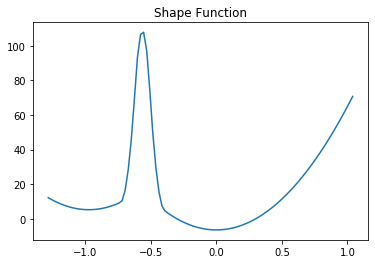

In [26]:
clf.visualize()